In [32]:
import pandas as pd
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.grid_search import GridSearchCV
from collections import defaultdict
from pandas.plotting import scatter_matrix
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

import locale
locale.setlocale( locale.LC_ALL, '' )

np.random.seed(1234)

# Functions 

In [2]:
def plotFittingCurve(grid_summary, param):
    if len(param) == 1:
        fig, axes = plt.subplots(figsize=(8,6))
        x_val = grid_summary[param]
        max_score_idx = grid_summary.mean_validation_score.argmax()
        
        axes.plot(x_val, grid_summary['mean_validation_score'], 'C0', label='Mean AUC')
        
        lower = grid_summary['mean_validation_score'] - grid_summary['std_err']
        axes.plot(x_val, lower, 'C0', label='-1 Std.Err', linestyle='--')
        
        upper = grid_summary['mean_validation_score'] + grid_summary['std_err']
        axes.plot(x_val, upper, 'C0', label='+1 Std.Err', linestyle='--')
        
        best_lower = grid_summary.mean_validation_score.max() - grid_summary.std_err[max_score_idx]
        xmin = x_val.min()
        xmax = x_val.max()
        plt.hlines(xmin=xmin, xmax=xmax, y=best_lower, color='r')

        plt.legend()
        plt.tight_layout()
        plt.title("Learning Curve: " + str(param))
        
    else:
        fig, axes = plt.subplots(figsize=(8,6))
        plt_data = pd.pivot_table(grid_summary, index=param[0], columns=param[1])
        col_max = plt_data['mean_validation_score'].max().idxmax()
        row_max = plt_data['mean_validation_score'][col_max].idxmax()
        
        plt_data['mean_validation_score'].plot(ax=axes, figsize=(8,6))
        
        upper = (plt_data['mean_validation_score'] + plt_data['std_err'])
        upper.plot(ax=axes, figsize=(8,6),alpha=0.25,linestyle='--')
        
        lower = (plt_data['mean_validation_score'] - plt_data['std_err'])
        lower.plot(ax=axes, figsize=(8,6),alpha=0.25,linestyle='--')
        
        best_lower = plt_data['mean_validation_score'].loc[row_max, col_max] - \
                                plt_data['std_err'].loc[row_max, col_max]
        xmin = plt_data.index.values.min()
        xmax = plt_data.index.values.max()
        plt.hlines(xmin=xmin, xmax=xmax, y=best_lower, color='r')
        
        plt.title("Learning Curve: " + str(param))
        
        
def gridSearchSummary(grid_search):
    grid_summary = pd.DataFrame(grid_search.grid_scores_)
    
    params_summary = defaultdict(list)
    for row in grid_summary.parameters:
        for key, value in row.items():
            params_summary[key] += [value]
    params_summary_df = pd.DataFrame(params_summary)
    
    grid_summary.drop('parameters', 1, inplace=True)
    grid_summary = params_summary_df.join(grid_summary)
    std_err = grid_summary.cv_validation_scores.apply(lambda x: np.sqrt(np.var(x)/len(x)))
    grid_summary.insert(grid_summary.columns.get_loc("mean_validation_score")+1, 'std_err', std_err)
    
    return grid_summary


def tuningIteration(estimator, param_grid, X, Y, pipeline=None):
    if pipeline == None:
        pipeline = Pipeline([('variance_thresh', VarianceThreshold()), ('estimator', estimator)])
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=10, scoring='roc_auc')
    grid_search.fit(X, Y)
    print("Best Score: {:0.6}\n".format(grid_search.best_score_))
    print("Best Params: ",grid_search.best_params_)
    grid_summary = gridSearchSummary(grid_search)
    plotFittingCurve(grid_summary, list(param_grid.keys()))
    

def expectedValue(preds, truth, thresholds, fp_cost, fn_cost, pos_prior=0.15):
    # fp_cost and fn_cost should be the change in revenue associated with 1000 ad requests (i.e. rCPM change)
    # output of expected value is the expected rCPM 
    
    class_preds = list(map(lambda x, y: 1 if x > y else 0, preds, thresholds))
    
    tn, fp, fn, tp = confusion_matrix(truth, class_preds).ravel()
    fp_rate = np.true_divide(fp, fp+tn)
    fn_rate = np.true_divide(fn, fn+tp)
    
    ev = pos_prior*(fn_rate*fn_cost) + (1-pos_prior)*(fp_rate*fp_cost)
    
    return ev

def calculateProfit(preds, truth, fp_cost, fn_cost, timeframe):
    fpr, tpr, thresholds = roc_curve(Y_test, preds)
    rcpm_change = []
    pct_instance = []
    for each_thresh in thresholds:
        rcpm_change += [expectedValue(preds, Y_test, [each_thresh]*len(Y_test), fp_cost, fn_cost)]
        pct_instance_thresh = np.sum(preds > each_thresh)/len(Y_test)    
        pct_instance += [pct_instance_thresh]

    if timeframe=='yearly':
        profit = list(map(lambda x: x/1000*12*450*10**9, rcpm_change))
    elif timeframe=='monthly':
        profit = list(map(lambda x: x/1000*450*10**9, rcpm_change))
    else:
        raise ValueError('timeframe must be "yearly" or "monthly"')

    profit_df = pd.DataFrame({'pct_instance': pct_instance, 'profit': profit, 'rcpm_change': rcpm_change})
    profit_df = profit_df.sort_values('pct_instance')
    profit_df['profit_change'] = profit_df.profit.transform(lambda x: (x/x[0]-1)*-1)
    profit_df['profit_diff'] = profit_df.profit.transform(lambda x: (x-x[0]))
    
    max_idx = profit_df.profit_change.idxmax()
    max_profit_change = profit_df.profit_change.iloc[max_idx]
    max_profit_diff = profit_df.profit_diff.iloc[max_idx]
    max_profit_pct_instance = profit_df.pct_instance.iloc[max_idx]
    
    return profit_df, max_profit_change, max_profit_diff, max_profit_pct_instance


def getPredictions(pipelines, X, Y, x_test):
    preds = []
    for pipeline in pipelines:
        pipeline.fit(X, Y)
        estimator = pipeline.named_steps['estimator']
        if isinstance(estimator, GradientBoostingClassifier) | isinstance(estimator, SVC):
            preds += [pipeline.decision_function(x_test)]
        else:
            preds += [pipeline.predict_proba(x_test)[:,1]]
            
    return preds


def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)


def to_percent(x, pos):
    'The two args are the value and tick position'
    return '%.0f%%' % (x*100)


def plotROC(preds_zip, ax):
    pct_formatter = FuncFormatter(to_percent)
    
    for each_preds, each_model in preds_zip:
        fpr, tpr, thresholds = roc_curve(Y_test, each_preds)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = each_model+" (AUC = {:0.3})".format(roc_auc))

    ax.set_title("Comparison of ROC Curves on Test Data")
    ax.set_xlabel("fpr")
    ax.set_ylabel("tpr")
    ax.yaxis.set_major_formatter(pct_formatter)
    ax.xaxis.set_major_formatter(pct_formatter)
    ax.legend()
    

def plotProfitChange(preds_zip, ax, Y_test, fp_cost, fn_cost, timeframe):
    pct_formatter = FuncFormatter(to_percent)
    
    for each_preds, each_model in preds_zip:
        profit_df, max_profit_change,\
        max_profit_diff, max_profit_pct_instance =\
        calculateProfit(each_preds, Y_test, fp_cost, fn_cost, timeframe)

        ax.plot(profit_df.pct_instance, profit_df.profit_change,
                     label = each_model+" Max: {:0.1%} Pct Inst.: {:0.1%}".format(
                         max_profit_change,max_profit_pct_instance))
        ax.yaxis.set_major_formatter(pct_formatter)
        ax.xaxis.set_major_formatter(pct_formatter)

    ax.set_title("Comparison of Profit Curves (Cost Reduction) on Test Data")
    ax.set_xlabel("Percentage of Test Instances")
    ax.set_ylabel("Expected Profit Improvement (Cost Reduction)")
    ax.legend()
    

def plotProfitDiff(preds_zip, ax, Y_test, fp_cost, fn_cost, timeframe):
    mil_formatter = FuncFormatter(millions)
    pct_formatter = FuncFormatter(to_percent)
    
    for each_preds, each_model in preds_zip:
        profit_df, max_profit_change,\
        max_profit_diff, max_profit_pct_instance =\
        calculateProfit(each_preds, Y_test, fp_cost, fn_cost, timeframe)

        ax.plot(profit_df.pct_instance, profit_df.profit_diff,
                     label = each_model+" Max: {}M Pct Inst.: {:0.1%}".format(
                         locale.currency(max_profit_diff*10**-6,grouping=True),max_profit_pct_instance))
        ax.yaxis.set_major_formatter(mil_formatter)
        ax.xaxis.set_major_formatter(pct_formatter)

    ax.set_title("Comparison of Profit Curves (Cost Reduction) on Test Data")
    ax.set_xlabel("Percentage of Test Instances")
    ax.set_ylabel("Expected Profit Improvement (Cost Reduction)")
    ax.legend()

    
def plotPerformance(pipelines, names, X_train, Y_train, X_test, Y_test,
                    fp_cost=-0.03, fn_cost=-0.06, timeframe='yearly'):
    
    # fp_cost based on Mopub rcpm
    # fn_cost = 2x fp_cost - Assume buyers act broadly because of a single bad actor
    # Twitter ad exchange request volume estimate:  
    #   https://media.mopub.com/media/filer_public/22/b5/22b58fbf-b077-4c2c-ae41-d53d06d23dd9/mopub_global_mobile_programmatic_trends_report_-_q2_2016.pdf
            
    preds = getPredictions(pipelines, X_train, Y_train, X_test)    
    preds_zip = list(zip(preds, names))
    
    fig = plt.figure(figsize=(14,14))
    gs = gridspec.GridSpec(2, 4)
    gs.update(wspace=0.5)
    axes = [plt.subplot(gs[0, :2], ), plt.subplot(gs[0, 2:]), plt.subplot(gs[1, 1:3])]
    
    plotProfitChange(preds_zip, axes[0], Y_test, fp_cost, fn_cost, timeframe)
    plotProfitDiff(preds_zip, axes[1], Y_test, fp_cost, fn_cost, timeframe)
    plotROC(preds_zip, axes[2])   
    
    
def modBootstrapper(train, test, nruns, sampsize, pipeline, label):
    X_test = test.drop('label',1)
    Y_test = test.label
    
    aucs = []
    for i in range(nruns):
        train_sample = train.iloc[np.random.randint(0,train.shape[0], size = sampsize)]
        X_train = train_sample.drop('label',1)
        Y_train = train_sample.label
        
        pipeline.fit(X_train, Y_train)
        estimator = pipeline.named_steps['estimator']
        if isinstance(estimator, GradientBoostingClassifier) | isinstance(estimator, SVC):
            preds = pipeline.decision_function(X_test)
        else:
            preds = pipeline.predict(X_test)

        roc_auc = roc_auc_score(Y_test, preds)
        aucs += [roc_auc] 
        
    mean_auc = np.mean(aucs)
    stderr_auc = np.sqrt(np.var(aucs))
    
    return mean_auc, stderr_auc

# Load Data

In [3]:
# Load transformed data
cwd = os.getcwd()
datadir = cwd + os.sep + 'data' + os.sep

def loadSentimentData(fileName):
    data = pd.read_csv(datadir + fileName, header=0, index_col=0)
    data.dropna(inplace=True)
    data.drop(['arousal_mv','valence_mv','label'], 1, inplace=True)
    data.index = data.index.astype('int64')
    
    return data

def loadUserData(fileName):
    data = pd.read_csv(datadir + fileName, header=0, encoding="cp1252")
    data = data[['id','favourites_count','followers_count','friends_count',
                 'listed_count','statuses_count', 'label', 'default_profile',
                 'default_profile_image','verified','reputation','taste']]
    data.set_index('id', inplace=True)
    data.dropna(inplace=True)
    
    return data

def loadTimingData(fileName):
    data = pd.read_csv(datadir + fileName, header=0)
    data.set_index('user_id', inplace=True)
    
    return data

def loadData(fileNames):
    sentiment = loadSentimentData(fileNames[0])
    account = loadUserData(fileNames[1])
    timing = loadTimingData(fileNames[2])
    data = account.join(sentiment, how='left')
    data = data.join(timing, how='left')
    
    mv_cols = (pd.isnull(data)).any().drop('label')
    for each_col, each_bool in zip(mv_cols.index.values, mv_cols):
        if each_bool == True:
            data[each_col+'_mv'] = np.where(pd.isnull(data[each_col]), 1, 0)
            col_mean = data[each_col].mean()
            data[each_col] = data[each_col].fillna(col_mean)
        
    return data
    
# data = loadData(['sentiment_dist_varol_dump.csv','varol-2017-users.csv','timing.csv'])
data = loadData(['sentiment_dist_varol_dump.csv','merged.csv','timing.csv'])

# Feature Selection

In [4]:
# Train test split
sample_filt = np.random.uniform(0,1, data.shape[0]) < 0.8

X_train = data[sample_filt].drop('label',1)
Y_train = data[sample_filt].label
X_test = data[~sample_filt].drop('label',1)
Y_test = data[~sample_filt].label

In [5]:
# DecisionTree for MI scores
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

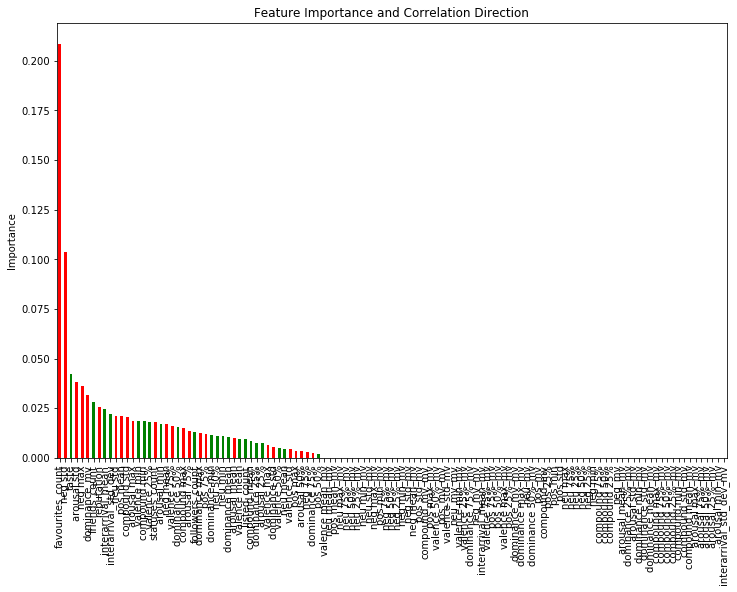

In [6]:
# Get importance and correlation
features_summary = pd.DataFrame(list(zip(X_train.columns, dt.feature_importances_)), 
                                columns=['feature','importance']).set_index('feature')
features_summary = features_summary.sort_values('importance', ascending=False)

corr_df = pd.DataFrame(data.corr()['label'].drop('label'))
corr_df.columns = ['correlation']

features_summary = features_summary.merge(corr_df, right_index=True, left_index=True)

# Plot importance and correlation
color_list = ['r' if corr < 0 else 'g' for corr in features_summary.correlation]
features_summary.importance.plot(kind='bar', color=color_list, figsize=(12,8))
plt.title('Feature Importance and Correlation Direction')
plt.ylabel('Importance')

# Select features
keep_features = features_summary[features_summary.importance > 0].index.values

In [7]:
# Discard features
X_train_filt = X_train[keep_features]
X_test_filt = X_test[keep_features]

# EDA & PCA

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a151dbd30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1ad4bac8>]], dtype=object)

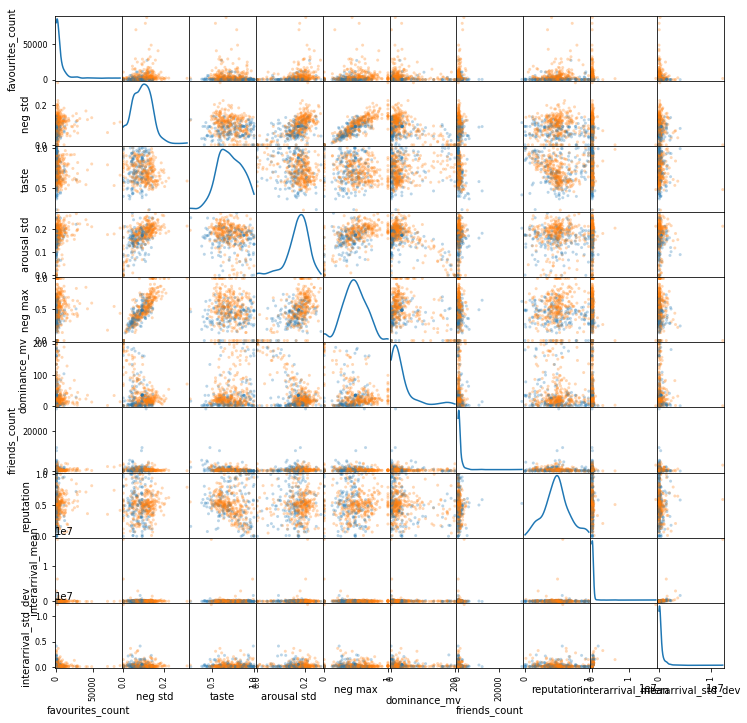

In [8]:
scatter_matrix(X_test[features_summary.head(10).index], alpha=0.3, figsize=(12, 12), diagonal='kde',
              color=np.where(Y_test==1,'C0','C1'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b316438>,
        ...,
        ...,
        ...,
       ..., 
        ...,
        ...,
        ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a4e030470>]], dtype=object)

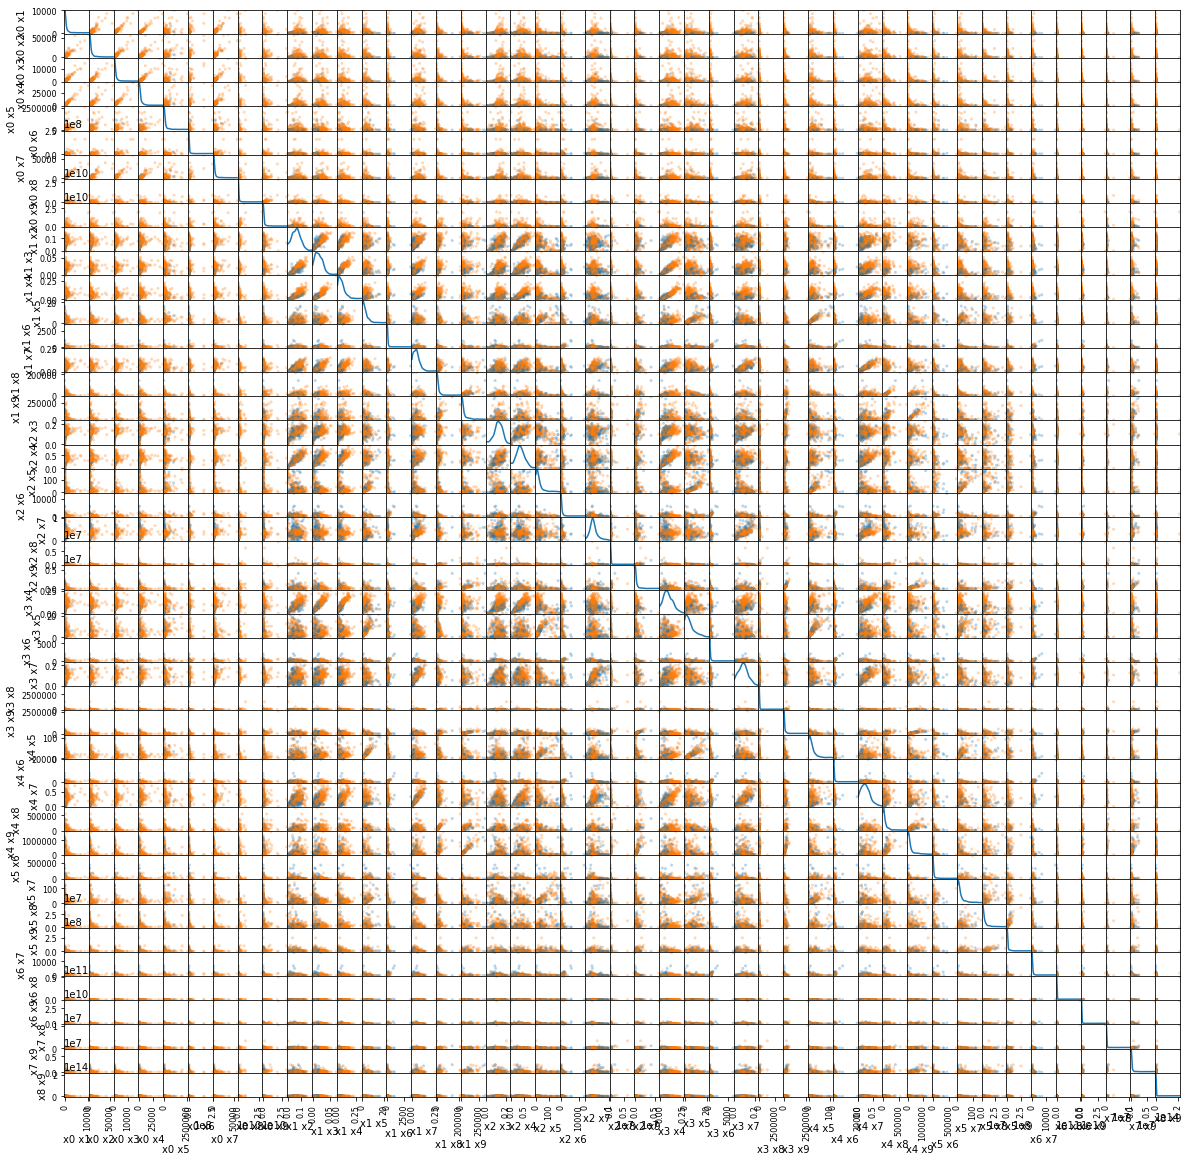

In [9]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_test_poly = pd.DataFrame(poly.fit_transform(X_test[features_summary.head(10).index]),
                           columns=poly.get_feature_names(),
                           index = X_test.index)

scatter_matrix(X_test_poly.iloc[:,11:], alpha=0.3, figsize=(20, 20), diagonal='kde',
              color=np.where(Y_test==1,'C0','C1'))

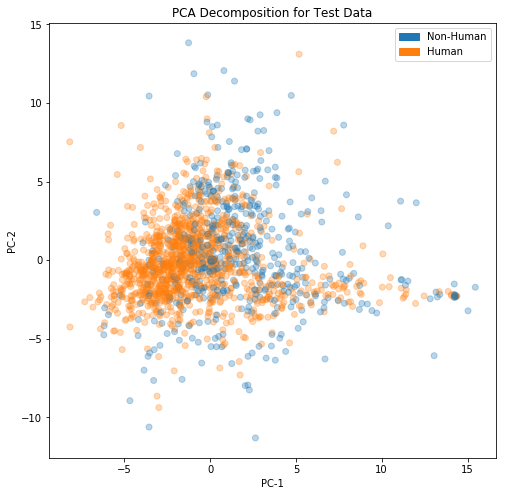

In [10]:
X_train_norm = pd.DataFrame(scale(X_train_filt, axis=0, with_mean=True, with_std=True, copy=True),
                            columns = X_train_filt.columns.values,
                            index = X_train_filt.index.values)

pca = PCA()
pca.fit(X_train_norm)

principle_components_df = pd.DataFrame(pca.transform(X_train_norm), index=X_train_norm.index)
principle_components_df = principle_components_df.join(Y_train)
fig, axes = plt.subplots(figsize=(8,8))
plt.scatter(principle_components_df.iloc[:,0],
            principle_components_df.iloc[:,1],
            color=['C0' if x==1 else 'C1' for x in principle_components_df['label']],
            alpha=0.3)
plt.title("PCA Decomposition for Test Data")
plt.xlabel("PC-1")
plt.ylabel("PC-2")
orange_patch = mpatches.Patch(color='C0', label='Non-Human')
blue_patch = mpatches.Patch(color='C1', label='Human')
plt.legend(handles=[orange_patch, blue_patch])

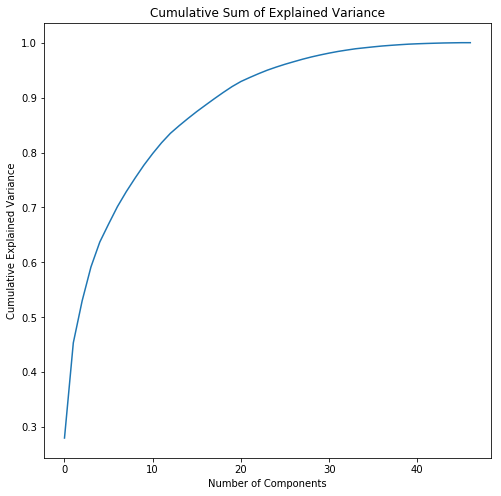

In [11]:
fig, axes = plt.subplots(figsize=(8,8))
axes.plot(pca.explained_variance_ratio_.cumsum())
plt.title("Cumulative Sum of Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

# Train Baseline Model

In [12]:
# Baseline Logistic Regression and SVM
lr = LogisticRegression()

kfold = KFold(10, True)
lr_cv = cross_val_score(lr, X_train, Y_train, cv = kfold, scoring="roc_auc")

In [13]:
print("LR Mean CV AUC Score: {:0.3}".format(np.mean(lr_cv))+
      "\nLR StdErr CV AUC Score: {:0.3}".format(np.sqrt(np.var(lr_cv)/len(lr_cv))))

LR Mean CV AUC Score: 0.738
LR StdErr CV AUC Score: 0.0169


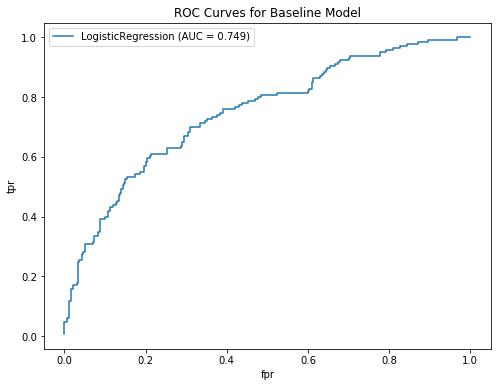

In [14]:
# ROC Curve for single test split baseline models
lr.fit(X_train_filt, Y_train)

lr_pos_class = lr.classes_==1
preds_lr = lr.predict_proba(X_test_filt)[:,lr_pos_class]
preds_zip = zip([preds_lr], ["LogisticRegression"])

fig, axes = plt.subplots(1,1, figsize=(8,6))
for each_preds, each_model in preds_zip:
    fpr, tpr, thresholds = roc_curve(Y_test, each_preds)
    roc_auc = auc(fpr, tpr)
    axes.plot(fpr, tpr, label = each_model+" (AUC = {:0.3})".format(roc_auc))

plt.title("ROC Curves for Baseline Model")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()

# Logistic Regression Tuning 

Best Score: 0.757742

Best Params:  {'estimator__C': 0.001, 'poly__degree': 2}


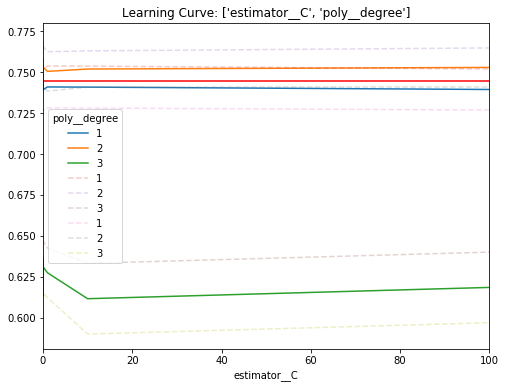

In [15]:
lr_pipeline = Pipeline([('variance_thresh', VarianceThreshold()),
                        ('poly', PolynomialFeatures()),
                        ('estimator', LogisticRegression())])

tuningIteration(LogisticRegression(),
                {'estimator__C': [10**x for x in range(-8,3)],
                 'poly__degree': [1,2,3]},
                X_train_filt, Y_train,
                lr_pipeline)

# SVM Tuning 

Best Score: 0.836001

Best Params:  {'estimator__C': 1, 'estimator__kernel': 'rbf'}


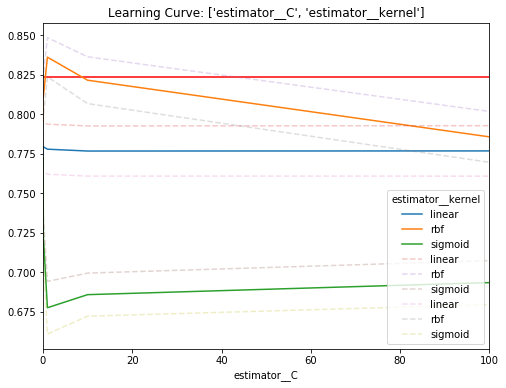

In [33]:
svm_pipeline = Pipeline([('variance_thresh', VarianceThreshold()),
                        ('normalize', StandardScaler()),
                        ('estimator', SVC())])

tuningIteration(SVC(),
                {'estimator__C': [10**x for x in range(-8,3)],
                  'estimator__kernel': ['linear','rbf','sigmoid']},
                X_train_filt, Y_train,
                svm_pipeline)

# Bagging Logistic Classifier

## Iteration 1

Best Score: 0.802265

Best Params:  {'estimator__base_estimator__C': 1, 'estimator__max_features': 0.3, 'estimator__max_samples': 0.7, 'estimator__n_estimators': 50}


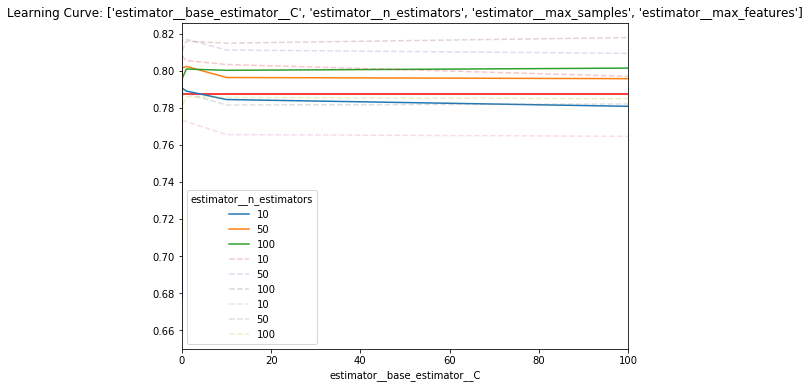

In [18]:
tuningIteration(BaggingClassifier(LogisticRegression()),
               {'estimator__base_estimator__C':[10**x for x in range(-8,3)],
               'estimator__n_estimators':[10, 50, 100],
               'estimator__max_samples':[0.7],
               'estimator__max_features':[0.3]},
               X_train_filt, Y_train, pipeline = None)

## Iteration 2

Best Score: 0.80876

Best Params:  {'estimator__max_features': 0.30000000000000004, 'estimator__max_samples': 0.30000000000000004}


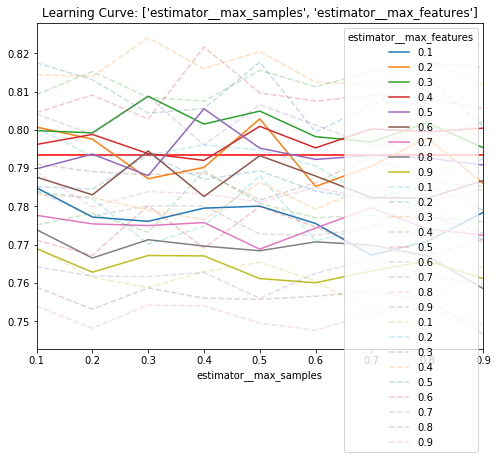

In [19]:
tuningIteration(BaggingClassifier(LogisticRegression(C = 10), n_estimators = 50),
               {'estimator__max_samples':np.arange(0.1,1,0.1),
               'estimator__max_features':np.arange(0.1,1,0.1)},
               X_train_filt, Y_train, pipeline = None)

## Iteration 3

Best Score: 0.808173

Best Params:  {'estimator__n_estimators': 130}


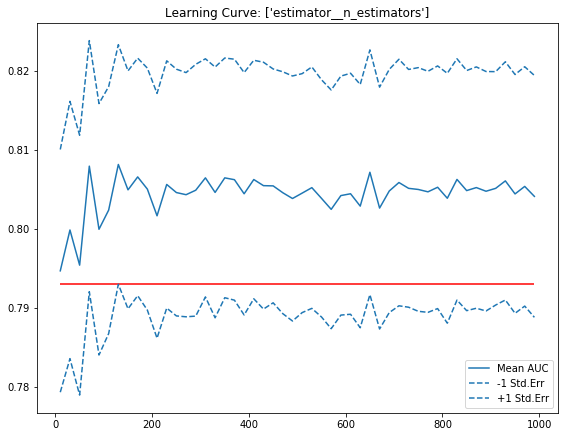

In [20]:
tuningIteration(BaggingClassifier(LogisticRegression(C = 10), max_features = 0.3, max_samples = 0.4),
               {'estimator__n_estimators': list(range(10,1000,20))},
               X_train_filt, Y_train, pipeline = None)

# GBM Tuning 

## Iteration 1

Best Score: 0.8603

Best Params:  {'estimator__n_estimators': 70}


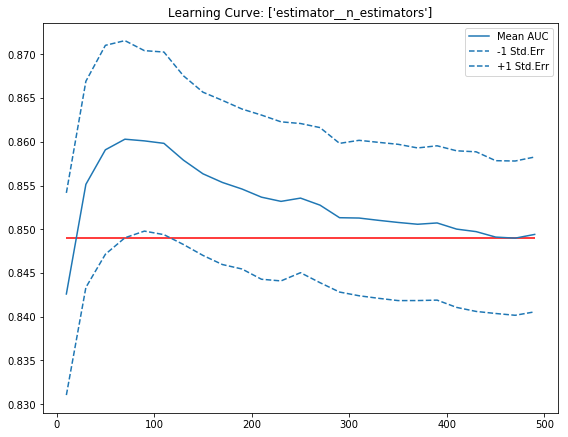

In [21]:
tuningIteration(GradientBoostingClassifier(),
                {'estimator__n_estimators': list(range(10,500,20))},
                X_train_filt, Y_train)

## Iteration 2 

Best Score: 0.864128

Best Params:  {'estimator__max_depth': 2}


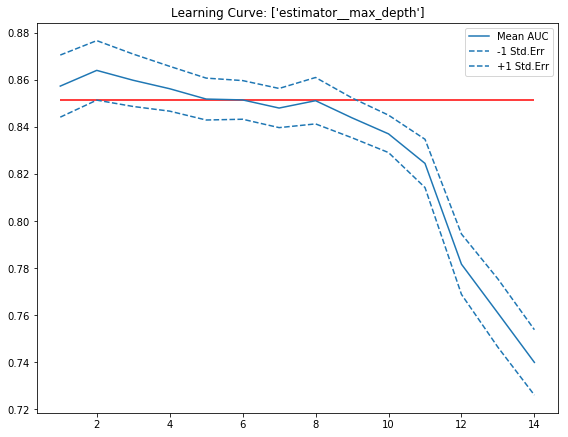

In [22]:
tuningIteration(GradientBoostingClassifier(n_estimators=70),
                {'estimator__max_depth': list(range(1,15))},
                X_train_filt, Y_train)

## Iteration 3

Best Score: 0.868355

Best Params:  {'estimator__min_samples_leaf': 85}


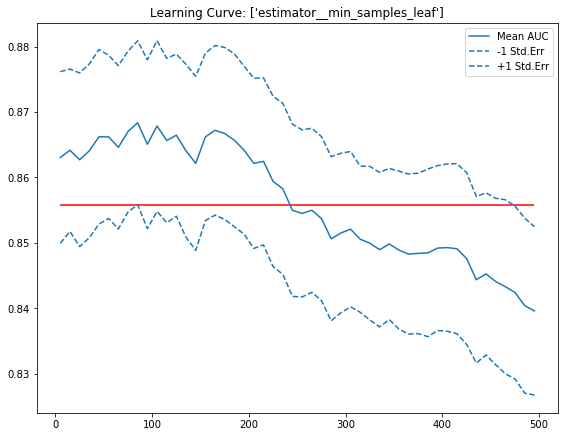

In [23]:
tuningIteration(GradientBoostingClassifier(n_estimators=70, max_depth=2),
                {'estimator__min_samples_leaf': list(range(5,500,10))},
                X_train_filt, Y_train)

## Iteration 4

Best Score: 0.868392

Best Params:  {'estimator__max_features': 20}


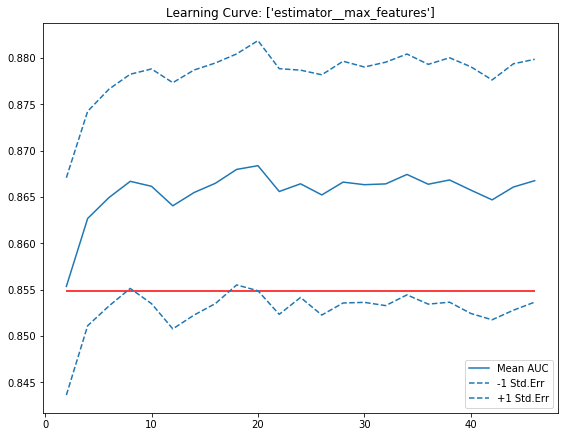

In [24]:
tuningIteration(GradientBoostingClassifier(n_estimators=70, max_depth=2, min_samples_leaf=105),
                {'estimator__max_features': list(range(2,X_train_filt.shape[1],2))},
                X_train_filt, Y_train)

## Iteration 5

Best Score: 0.868481

Best Params:  {'estimator__subsample': 1.0}


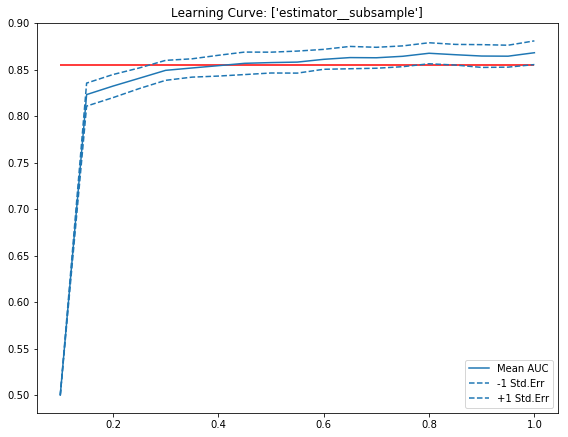

In [25]:
tuningIteration(GradientBoostingClassifier(n_estimators=70, max_depth=2, min_samples_leaf=105, max_features=8),
                {'estimator__subsample': np.array(list(range(10,105,5)))/100},
                X_train_filt, Y_train)

## Interation 6 

Best Score: 0.86831

Best Params:  {'estimator__learning_rate': 0.1, 'estimator__n_estimators': 190}


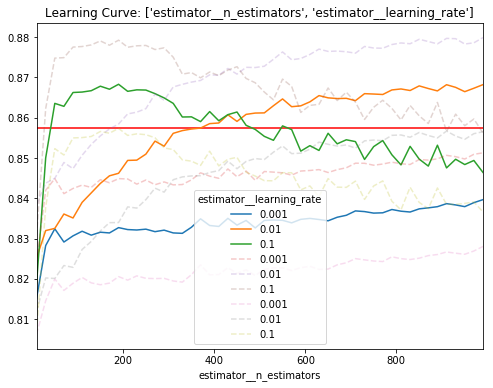

In [26]:
tuningIteration(GradientBoostingClassifier(n_estimators=70, max_depth=2, min_samples_leaf=105, max_features=8,
                                           subsample=0.75),
                {'estimator__n_estimators': list(range(10,1000,20)),
                 'estimator__learning_rate': [10**x for x in range(-3,0)]},
                X_train_filt, Y_train)

## Iteration 7 

Best Score: 0.86982

Best Params:  {'estimator__n_estimators': 1400}


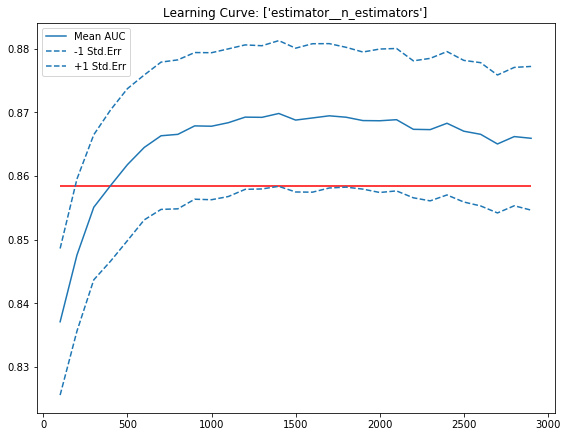

In [27]:
tuningIteration(GradientBoostingClassifier(n_estimators=70, max_depth=2, min_samples_leaf=105, max_features=8,
                                           subsample=0.75, learning_rate=0.01),
                {'estimator__n_estimators': list(range(100,3000,100))},
                X_train_filt, Y_train)

Best Score: 0.869053

Best Params:  {'feat_select__k': 45}


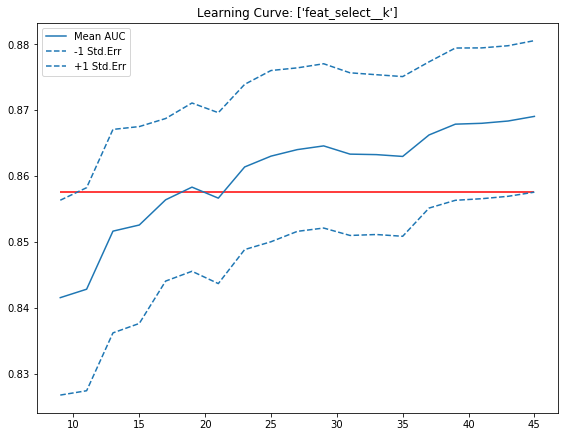

In [28]:
gbm_pipeline = Pipeline([('variance_thresh', VarianceThreshold()),
                         ('feat_select', SelectKBest(mutual_info_classif)),
                         ('estimator', GradientBoostingClassifier(n_estimators=1700, max_depth=2, min_samples_leaf=105, max_features=8,
                                           subsample=0.75, learning_rate=0.01))])

max_features = X_train_filt.shape[1] - X_train_filt.shape[1]%2

tuningIteration(GradientBoostingClassifier(),
                {'feat_select__k': list(range(9,max_features,2))},
                X_train_filt, Y_train,
                gbm_pipeline)

## Compare Results

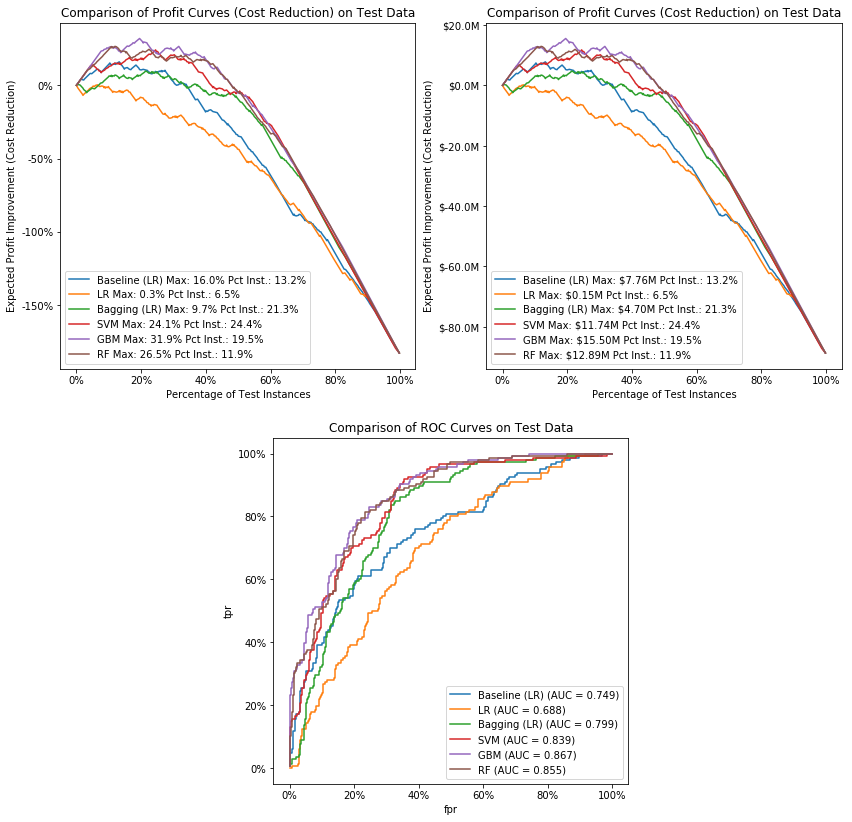

In [34]:
lr_baseline = Pipeline([('estimator', LogisticRegression(random_state=1234))])

lr_pipeline_final = Pipeline([('variance_thresh', VarianceThreshold()),
                              ('poly', PolynomialFeatures(2)),
                              ('estimator', LogisticRegression(C=10**-3, random_state=1234))])
                              
                              
svm_pipeline_final = Pipeline([('variance_thresh', VarianceThreshold()),
                               ('normalize', StandardScaler()),
                               ('estimator', SVC(C=1, kernel='rbf', random_state=1234))])

                              
gbm_pipeline_final = Pipeline([('variance_thresh', VarianceThreshold()),
                               ('estimator', GradientBoostingClassifier(n_estimators=1700,max_depth=2,
                                                                        min_samples_leaf=105, max_features=8,
                                                                        subsample=0.75, learning_rate=0.01,
                                                                        random_state=1234))])

rf_pipeline_final = Pipeline([('variance_thresh', VarianceThreshold()),
                               ('estimator', RandomForestClassifier(n_estimators=421,
                                                                    max_features=7,
                                                                    min_samples_leaf=8,
                                                                    min_samples_split=12,
                                                                    random_state=1234))])
bagging_lr_final = Pipeline([('variance_thresh', VarianceThreshold()),
                             ('estimator', BaggingClassifier(LogisticRegression(C = 10),
                                                            max_features = 0.3,
                                                            max_samples = 0.4,
                                                            n_estimators = 190))])

plotPerformance([lr_baseline, lr_pipeline_final, bagging_lr_final, svm_pipeline_final, gbm_pipeline_final, rf_pipeline_final],
                ["Baseline (LR)","LR",'Bagging (LR)', "SVM", "GBM", "RF"],
                X_train_filt, Y_train, X_test_filt, Y_test,
                -0.03, -0.06, 'yearly')

# Learning Curves

In [30]:
samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]
pipelines = [lr_baseline, lr_pipeline_final, bagging_lr_final, svm_pipeline_final, gbm_pipeline_final, rf_pipeline_final]
labels = ["Baseline (LR)","LR", "Bagging (LR)","SVM", "GBM", "RF"]

boot_results = defaultdict(list)
for i,pl in enumerate(pipelines):
    for each_samplesize in samplesizes:
        mean_auc, stderr_auc = modBootstrapper(X_train_filt.join(Y_train), X_test_filt.join(Y_test),
                                               20, each_samplesize, pl, labels[i])
        boot_results[labels[i]+"_mean_auc"] += [mean_auc]
        boot_results[labels[i]+"_stderr_auc"] += [stderr_auc]
        print(labels[i] + ' ' + str(each_samplesize) + ' done')

Baseline (LR) 50 done
Baseline (LR) 100 done
Baseline (LR) 200 done
Baseline (LR) 500 done
Baseline (LR) 1000 done
Baseline (LR) 1500 done
Baseline (LR) 2000 done
LR 50 done
LR 100 done
LR 200 done
LR 500 done
LR 1000 done
LR 1500 done
LR 2000 done


/Users/stephencarrow/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/stephencarrow/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/stephencarrow/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/stephencarrow/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/stephencarrow/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/stephencarrow/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/stephencarrow/anaconda/lib/python3.6/site-packages/

Bagging (LR) 50 done


/Users/stephencarrow/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/stephencarrow/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/stephencarrow/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/stephencarrow/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/stephencarrow/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/stephencarrow/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/stephencarrow/anaconda/lib/python3.6/site-packages/

Bagging (LR) 100 done
Bagging (LR) 200 done
Bagging (LR) 500 done
Bagging (LR) 1000 done
Bagging (LR) 1500 done
Bagging (LR) 2000 done
SVM 50 done
SVM 100 done
SVM 200 done
SVM 500 done
SVM 1000 done
SVM 1500 done
SVM 2000 done
GBM 50 done
GBM 100 done
GBM 200 done
GBM 500 done
GBM 1000 done
GBM 1500 done
GBM 2000 done
RF 50 done
RF 100 done
RF 200 done
RF 500 done
RF 1000 done
RF 1500 done
RF 2000 done


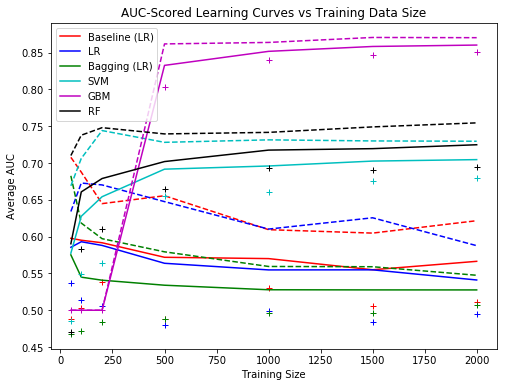

In [31]:
fig, axes = plt.subplots(1,1, figsize=(8,6))
x_values = samplesizes
colors = ['r', 'b', 'g', 'c', 'm', 'k']
i = 0

for label in labels:    
    axes.plot(x_values, boot_results[label +'_mean_auc'], colors[i], label = label)
    axes.plot(x_values, np.asarray(boot_results[label+ '_mean_auc']) - np.asarray(boot_results[label + '_stderr_auc'])*2, colors[i] + '+')
    axes.plot(x_values, np.asarray(boot_results[label+'_mean_auc']) + np.asarray(boot_results[label + '_stderr_auc'])*2, colors[i] + '--')
    i += 1
plt.title("AUC-Scored Learning Curves vs Training Data Size")
plt.xlabel("Training Size")
plt.ylabel("Average AUC")
plt.legend()
plt.show()
plt.savefig("Learning_Curves.jpg")